In [1]:
import pandas as pd
import numpy as np

# 1. Data Acquaintance

## 1.1 Load data

In [2]:
us_acc = pd.read_csv('US_Accidents_Dec21_updated.csv')

## 1.2 First glance + Read the paper
We use ProfileReport, an Exploratory Data Analysis (EDA) to have a first glance of the data. We examine type of attributes, missing values, distributions, interactions and other characteristics. Also, before procceding we read the paper which accompanies the dataset in order to extract meaningful information such as the data extraction and augmentation processes.

In [3]:
# Run only once! Uncomment if profile.html does not exist
# from pandas_profiling import ProfileReport

# profile = ProfileReport(data, title="Report")
# profile.to_file('profile.html')

# 2 Data engineering
## 2.1 Drop unnecessary attributes
- <b>ID:</b> Indifferent.
- <b>Description:</b> The information is captured by rest variables such as <i>Junction, Stop, No_Exit</i> ect as referred in section 4.2.3 of the paper.
- <b>Number, Street, Country, County, State, Zipcode:</b> The information is captured either by the augmented variables (a specific street has rounabouts, stops, etc in every record) or implicitly by the lon, lat. In this step, we keep City to impute missing weather data (mean of city's weather data).
- <b>Airport_Code:</b> Indifferent.
- <b>Timezone:</b> Event timestamp will remain in local time to capture the local conditions in every timezone for even comparisons.
- <b>Weather_Timestamp:</b> This could just be used here for analyzing the deviation from event timestamps, but it's already done in section 4.2.2 of the paper.
- <b>Wind_Chill:</b> We can observe a high linear correlation with Temperature.
- <b>Wind_Direction:</b> We supposed that it couldn't further help us in our analysis. Additionally, its preproccesing requires too much effort due to high cardinality and duplications which have to be treated manually.
- <b>Turning_Loop:</b> Constant.
- <b>Sunrise_Twilight, Civil_Twilight, Nautical_Twilight:</b> The remaining twilight (Astronomical_Twilight) is supposed to be more influential factor for accidents. 

In [4]:
data_df = us_acc.drop(['ID', 'Description', 'Number', 'Street', 
                  'County', 'State', 'Zipcode', 'Country',
                  'Timezone', 'Weather_Timestamp', 'Airport_Code', 'Turning_Loop', 'Wind_Direction', 
                  'Wind_Chill(F)', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'], axis=1) 
                  

## 2.2 Data Transformation
Here we do minor alternations on data types and values. More specifically, data type casting, column renaming and drop, value replacement and drop, grouping of similar categorical values.

In [5]:
data_df['Start_Time'] = pd.to_datetime(data_df['Start_Time']).dt.date
data_df['End_Time'] = pd.to_datetime(data_df['End_Time']).dt.date

data_df = data_df.rename({'Distance(mi)': 'Distance',
                    'Temperature(F)': 'Temperature',
                    'Humidity(%)': 'Humidity',
                    'Pressure(in)': 'Pressure',
                    'Visibility(mi)': 'Visibility',
                    'Wind_Speed(mph)': 'Wind_Speed',
                    'Precipitation(in)': 'Precipitation'}, axis=1)

# a 'N' value exists, so we drop row + to boolean
data_df.loc[:, 'Side'] = data_df.loc[data_df['Side'] != 'N']['Side'].replace({'R': 1, 'L': 0})
data_df.loc[:, 'Astronomical_Twilight'] = data_df['Astronomical_Twilight'].replace({'Day': 1, 'Night': 0})

# 'Tornado' appears in 8 records, pretty low representation, so we drop it. 
data_df.loc[:, 'Weather_Condition'] = data_df.loc[data_df['Weather_Condition'] != 'Tornado', 'Weather_Condition']

# Reducing the number of possible categorical values
data_df.loc[:, 'Weather_Condition'] = data_df['Weather_Condition'].replace(to_replace={
                                r'^.*(Rain|Squalls|Drizzle|Showers|Thunderstorm|Precipitation|Wintry|Sleet).*$': 'Rain',
                                r'^.*(Cloud|Overcast).*$': 'Cloudy',
                                r'^.*(Snow|Pellets|Hail).*$': 'Snow',
                                r'^.*(Fog|Haze|Mist|Smoke).*$': 'Fog',
                                r'^.*(Thunder|T-Storm).*$': 'Thunder',
                                r'^.*(Dust|Sand|Ash).*$': 'Dust',
                                r'^.*(Clear|Fair).*$': 'Fair'}, regex=True)

# Specific label categorical encoding, from good weather to bad
data_df.loc[:, "Weather_Condition"] = data_df['Weather_Condition'].replace({"Fair": 0,
                                                                            "Cloudy": 1,
                                                                            "Fog": 2,
                                                                            "Dust": 3,
                                                                            "Rain": 4,
                                                                            "Thunder": 5,
                                                                            "Snow": 6})
                                                                
# There are few nans so we can drop the respective rows
data_df = data_df.dropna(subset=['Weather_Condition', 'Side', 'Astronomical_Twilight'])

# Bool variables to 0/1
bool_lbls = ['Amenity', 'Side', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 
            'Roundabout', 'Station', 'Stop','Traffic_Calming', 'Traffic_Signal', 'Astronomical_Twilight']
data_df[bool_lbls] = data_df[bool_lbls].astype(int)


## 2.3 Data cleaning
By observing the distributions and statistics for each variable from the report, we are able to detect abnormal values which may be noise or natural extreme values. We want to clean the data by choosing appropriate thresholds and cutting off the outliers.

In [6]:
data_df = data_df.loc[(data_df['Temperature'] < 120) &
                      (data_df['Pressure'] < 50) &
                      (data_df['Pressure'] > 10) &
                      (data_df['Visibility'] < 100) &
                      (data_df['Wind_Speed'] < 300) &
                      (data_df['Precipitation'] < 15)]

## 2.4 Data imputation
After the above preprocessing, there are no missing values but in weather data. We fill the missing data with the mean value of the attribute per city.

In [7]:
labels = ['Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed', 'Precipitation']
average_per_city = data_df.groupby('City')[labels].mean().reset_index()
for label in labels:
    data_df.loc[pd.isna(data_df[label]), label] = pd.merge(data_df
                                .loc[pd.isna(data_df[label]), 'City'], average_per_city, on='City')[label]

# After the imputation, there may be nan values due to lack of data for a city, so we finally drop them
data_df = data_df.dropna(subset=labels)

# 3 Clustering
Clustering tries to find out data clusters, i.e. groups of points that are similar, using a metric. In clustering, the similarity is consindered in terms of distance in space, so nearby points are more similar to each other than distant ones.

## 3.1 Data preprocessing
We select the columns, aka the dimensions in which the clustering will happen. We ignore some columns:
- Start_Time, End_Time (timestamps) do not help us in our analysis
- Start_Lat, Start_Lng, End_Lat, End_Lng we want to focus on clustering based on other charasterics rather than geographical information

Severity is kept out for two reasons: 
- Severity has great impact on clustering since it seperates clsuters well
- Use it as target value for supervise classification

In [8]:
columns = ['Distance', 'Side', 'Temperature', 'Humidity',
       'Pressure', 'Visibility', 'Wind_Speed', 'Precipitation',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Astronomical_Twilight']

X = data_df[columns].values
y = data_df['Severity'].values

13 out of 22 variables are binary (0, 1), which means distance metrics do not properly express similarities (https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided). Also, distance metrics prefer values that are in same scale, so we use StandardScaler.

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(X[:, :9])
X_scaled = np.concatenate([X_scaled, X[:, 9:]], axis=1)

## 3.2 Searching for insights through clustering
Due to the large volume of data, we should use a quick clustering algorithm, such as KMeans. In order to find characteristics in clusters without using any target we can iterate through different clustering configurations and then train a supervised model to get feature importances. (https://www.quora.com/How-do-I-understand-the-characteristics-of-each-cluster-when-doing-a-K-Means-clustering-algorithm)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler 

def get_variable_importances(X, labels):
    importances = []
    for lbl in np.unique(labels):
        y_bool= np.where(labels == lbl, 1, 0)
        X_und, y_und = RandomUnderSampler(random_state=1).fit_resample(X, y_bool)
        dtc = DecisionTreeClassifier(random_state=1)
        dtc.fit(X_und, y_und)
        importances.append(dtc.feature_importances_)
    return np.array(importances)

In [11]:
from sklearn.cluster import KMeans

importances_list = []
cluster_severity_list = []
n_clusters = [2, 4, 8]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(X_scaled)
    importances = get_variable_importances(X_scaled, kmeans.labels_)
    importances_list.append(pd.DataFrame(data=importances, columns=columns))
    cluster_severity_list.append(pd.DataFrame(data={"Cluster": kmeans.labels_, "Severity": y}))
    

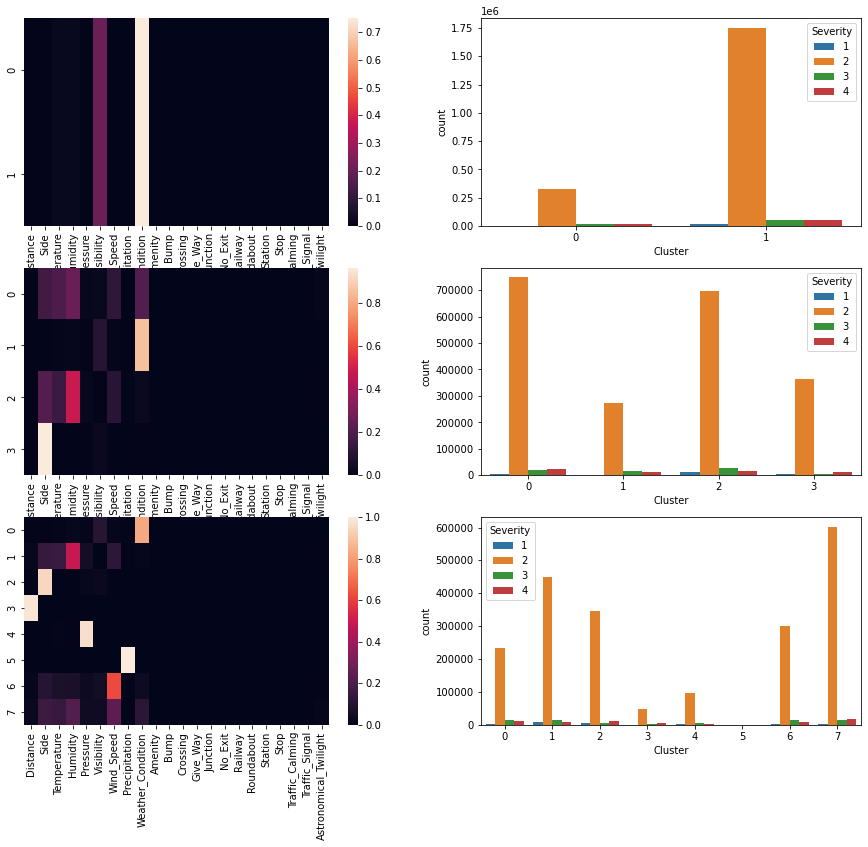

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# We plot cluster labels against Severity to find meaningful information about the unsupervised clustering.
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 13))
for i, imp in enumerate(importances_list):
    sns.heatmap(imp, square=False, ax=ax[i][0])
    sns.countplot(data=cluster_severity_list[i], x='Cluster', hue='Severity', ax=ax[i][1])
plt.show()

We can see the variable importances for each cluster which indicate the relative impact of each variable to the cluster. In other words, which variables characterize the cluster. For instance, for n=4 cluster #2 is characterized by the Side varbiable, whereas cluster #3 depends on Visibility and Weather_Condition. Thus, hidden correlations may emerge. 

## 3.3 Unsupervised classification

The goal here is to use three clustering methods for unsupervised classification. Here our target value is 'Severity' but we do not use it in the training phase. Even though scikit-learn library provides a number of clustering methods, they do not scale efficiently with data. Besides KMeans, other methods took much time to run, so we decided to reduce the data volume. <br>
Our strategy is:
- Use RandomUnderSampler to reduce the number of samples of each class = |minority_class|
- Reduce even more the number of samples by randomly sampling N=20_000 samples
- Reduce the number of dimensions

In [13]:
from imblearn.under_sampling import RandomUnderSampler

labels, counts = np.unique(y, return_counts=True)
print(f"Size before: {len(y)}")
print(f"Counts before: {dict(zip(labels, counts))}")


# Reduces to 94224 samples 
sampler = RandomUnderSampler(random_state=1)
X_reduced, y_reduced = sampler.fit_resample(X_scaled, y)

# but we need to reduce more
N = 20_000
np.random.seed(1)
random_index = np.random.choice(X_reduced.shape[0], N, replace=False)
X_sampled, y_sampled = X_reduced[random_index], y_reduced[random_index]

labels, counts = np.unique(y_sampled, return_counts=True)
print(f"\nSize after: {len(y_sampled)}")
print(f"Counts after: {dict(zip(labels, counts))}")

Size before: 2240862
Counts before: {1: 23556, 2: 2080281, 3: 71130, 4: 65895}

Size after: 20000
Counts after: {1: 5143, 2: 4925, 3: 4997, 4: 4935}


In [14]:
def plot_clustering(X, y=y_sampled, title="True labels"):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(*X.T, c=y)

    # Heatmap of number of predicted clusters against the severity. 
    ax = fig.add_subplot(1, 2, 2)
    temp = pd.DataFrame(data={"Cluster": y, "Severity": y_sampled})
    temp = temp.groupby(['Cluster', 'Severity'])['Severity'].count().rename('Count').reset_index()
    sns.heatmap(data=temp.pivot_table(values='Count', index='Severity', columns='Cluster'), square=True, cmap='Blues', vmin=0)
    fig.suptitle(title)

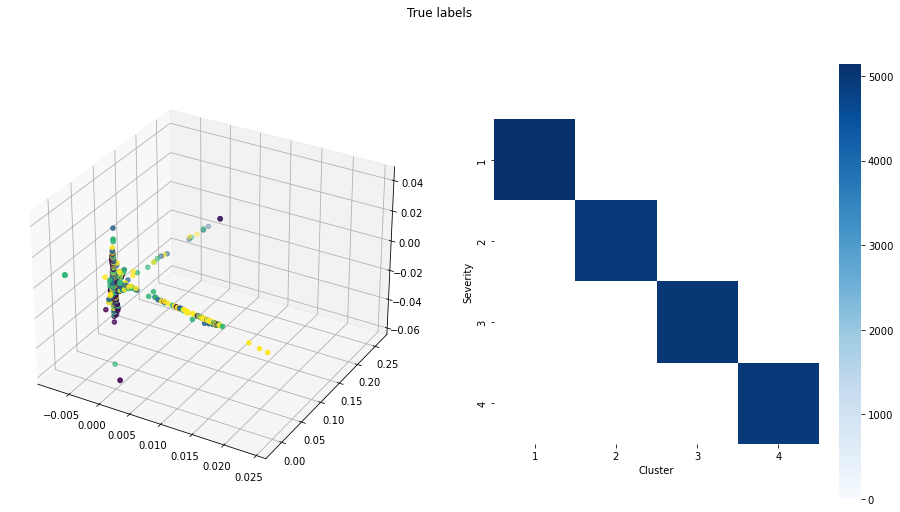

In [15]:
from sklearn.manifold import LocallyLinearEmbedding

# Then we reduce the number of dimensions
projection = LocallyLinearEmbedding(n_components=3, random_state=1).fit_transform(X_sampled)
plot_clustering(projection, y_sampled)

The chosen clustering methods are:
- KMeans
- DBSCAN
- Agglomerative Clsutering

We have tried various configurations for the hyper-parameters but we present the best we have found.

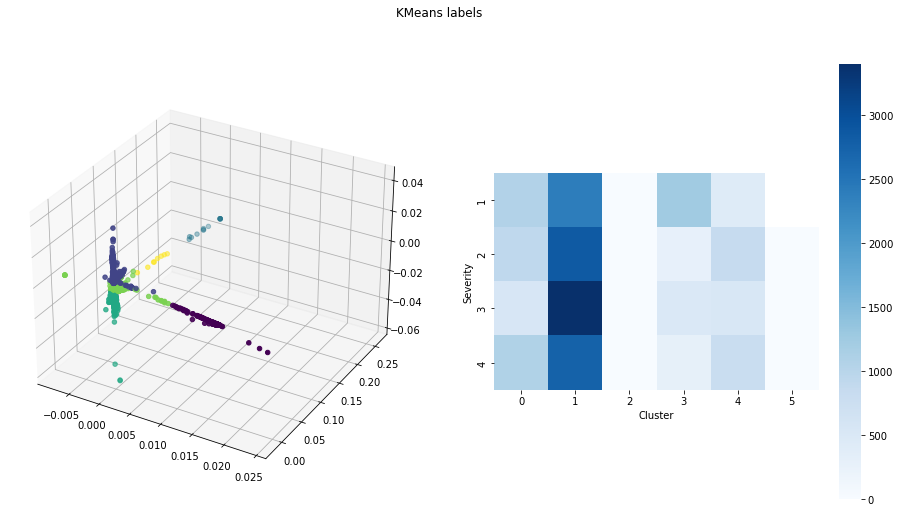

In [16]:
kmeans = KMeans(n_clusters=6, random_state=1)
labels_kmeans = kmeans.fit_predict(projection)
plot_clustering(projection, labels_kmeans, "KMeans labels")

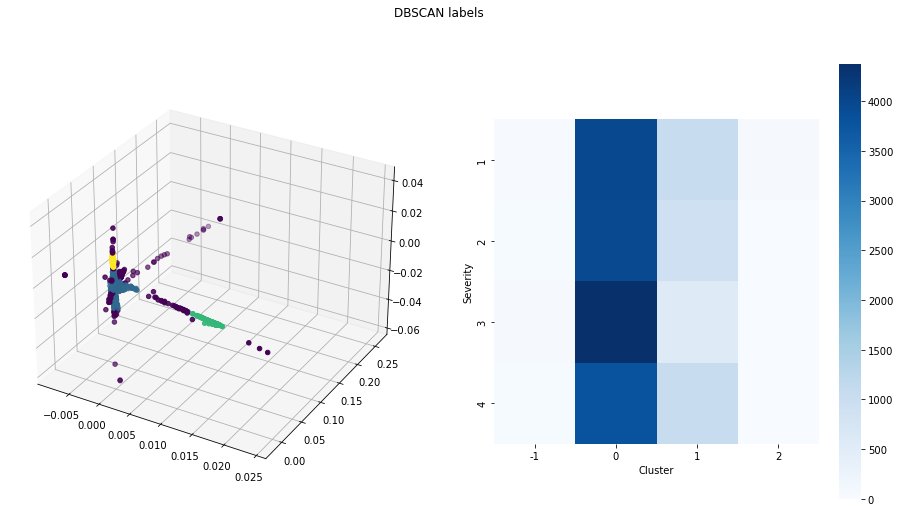

In [17]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.0015, min_samples=25)
labels_dbscan = dbscan.fit_predict(projection)
plot_clustering(projection, labels_dbscan, "DBSCAN labels")

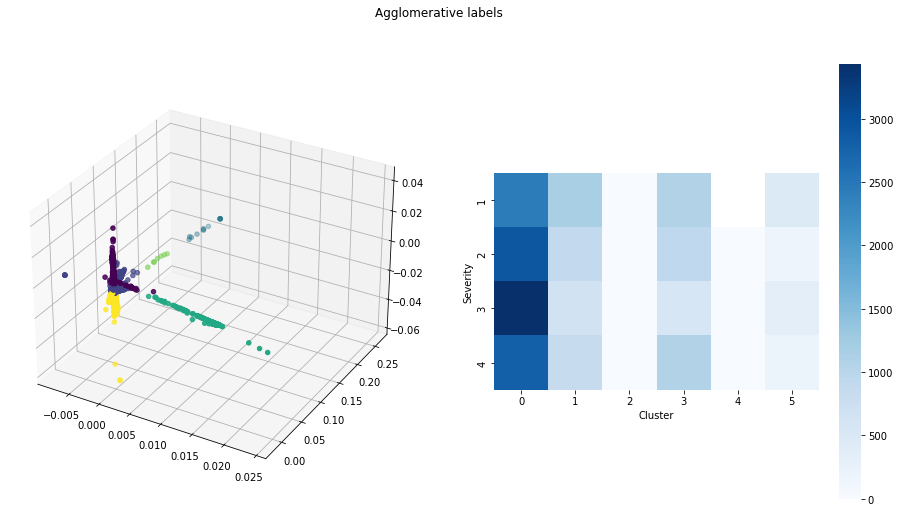

In [18]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=6)
labels_agglo = agglo.fit_predict(projection)
plot_clustering(projection, labels_agglo, "Agglomerative labels")

Finally, we present three boxplots of sample silhouette scores for each clustering method, as well as the respective adjusted rand index.

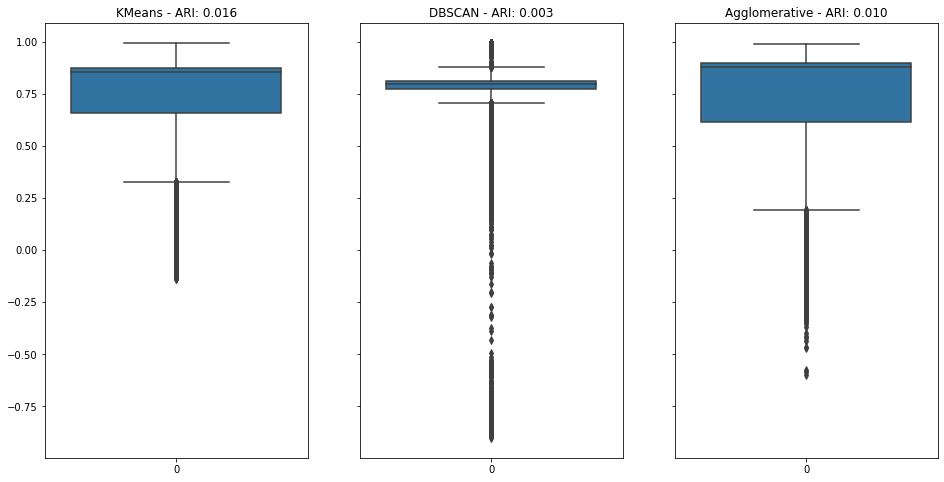

In [19]:
from sklearn.metrics import silhouette_samples, adjusted_rand_score

silh_scores = list(map(silhouette_samples, 
                       [projection]*3, 
                      [labels_kmeans, labels_dbscan, labels_agglo]))
amis = list(map(adjusted_rand_score, 
                [y_sampled]*3, 
                [labels_kmeans, labels_dbscan, labels_agglo]))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8), sharey=True)
sns.boxplot(data=silh_scores[0], ax=ax[0])
ax[0].set_title('KMeans - ARI: {:.3f}'.format(amis[0]))

sns.boxplot(data=silh_scores[1], ax=ax[1])
ax[1].set_title('DBSCAN - ARI: {:.3f}'.format(amis[1]))

sns.boxplot(data=silh_scores[2], ax=ax[2])
ax[2].set_title('Agglomerative - ARI: {:.3f}'.format(amis[2]))
plt.show()

# 4. Classification with NN
For the supervised classification, we have built three NN models we different hyper-parameter configurations and we benchmark their performance. Finally, we choose the best model and provide some interesting insights.

## 4.1 Data Preprocessing
First, we have to encode the target values to One-Hot and split the dataset to train (70%), validation (12%) and test (18%) parts. Note that the dataset has already been scaled and sampled.

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


enc = OneHotEncoder()
y_enc = enc.fit_transform(y_reduced.reshape(-1,1)).toarray()

X_train, X_val, y_train, y_val = train_test_split(X_reduced, y_enc, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.6)


## 3.2 Model Training

In [22]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

model_1 = Sequential()
model_1.add(Input(shape=(X_train.shape[1],)))
model_1.add(Dense(50, activation='sigmoid'))
model_1.add(Dense(35, activation='sigmoid'))
model_1.add(Dense(4, activation='softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history_1 = model_1.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_val, y_val))
predict_1 = model_1.predict(X_test)

Epoch 1/100
2062/2062 - 8s - loss: 1.2495 - accuracy: 0.4215 - val_loss: 1.2170 - val_accuracy: 0.4421 - 8s/epoch - 4ms/step
Epoch 2/100
2062/2062 - 7s - loss: 1.1965 - accuracy: 0.4524 - val_loss: 1.1860 - val_accuracy: 0.4527 - 7s/epoch - 3ms/step
Epoch 3/100
2062/2062 - 7s - loss: 1.1663 - accuracy: 0.4663 - val_loss: 1.1526 - val_accuracy: 0.4704 - 7s/epoch - 3ms/step
Epoch 4/100
2062/2062 - 6s - loss: 1.1362 - accuracy: 0.4805 - val_loss: 1.1350 - val_accuracy: 0.4664 - 6s/epoch - 3ms/step
Epoch 5/100
2062/2062 - 7s - loss: 1.1118 - accuracy: 0.4922 - val_loss: 1.1058 - val_accuracy: 0.4980 - 7s/epoch - 3ms/step
Epoch 6/100
2062/2062 - 7s - loss: 1.0957 - accuracy: 0.5004 - val_loss: 1.0932 - val_accuracy: 0.5059 - 7s/epoch - 3ms/step
Epoch 7/100
2062/2062 - 7s - loss: 1.0838 - accuracy: 0.5067 - val_loss: 1.0782 - val_accuracy: 0.5129 - 7s/epoch - 3ms/step
Epoch 8/100
2062/2062 - 7s - loss: 1.0728 - accuracy: 0.5140 - val_loss: 1.0717 - val_accuracy: 0.5139 - 7s/epoch - 3ms/step


In [23]:
model_2 = Sequential()
model_2.add(Input(shape=(X_sampled.shape[1],)))
model_2.add(Dense(125, activation='relu'))
model_2.add(Dense(86, activation='relu'))
model_2.add(Dense(49, activation='sigmoid'))
model_2.add(Dense(30, activation='relu'))
model_2.add(Dense(4, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history_2 = model_2.fit(X_train, y_train, batch_size=68, epochs=100, verbose=2, validation_data=(X_val, y_val))
predict_2 = model_2.predict(X_test)

Epoch 1/100
970/970 - 4s - loss: 1.1599 - accuracy: 0.4708 - val_loss: 1.0818 - val_accuracy: 0.5122 - 4s/epoch - 5ms/step
Epoch 2/100
970/970 - 4s - loss: 1.0612 - accuracy: 0.5219 - val_loss: 1.0439 - val_accuracy: 0.5355 - 4s/epoch - 4ms/step
Epoch 3/100
970/970 - 4s - loss: 1.0350 - accuracy: 0.5357 - val_loss: 1.0276 - val_accuracy: 0.5412 - 4s/epoch - 4ms/step
Epoch 4/100
970/970 - 4s - loss: 1.0175 - accuracy: 0.5453 - val_loss: 1.0305 - val_accuracy: 0.5394 - 4s/epoch - 4ms/step
Epoch 5/100
970/970 - 4s - loss: 1.0087 - accuracy: 0.5489 - val_loss: 1.0057 - val_accuracy: 0.5481 - 4s/epoch - 4ms/step
Epoch 6/100
970/970 - 4s - loss: 1.0012 - accuracy: 0.5528 - val_loss: 1.0093 - val_accuracy: 0.5534 - 4s/epoch - 4ms/step
Epoch 7/100
970/970 - 4s - loss: 0.9955 - accuracy: 0.5571 - val_loss: 1.0199 - val_accuracy: 0.5483 - 4s/epoch - 4ms/step
Epoch 8/100
970/970 - 4s - loss: 0.9920 - accuracy: 0.5567 - val_loss: 1.0118 - val_accuracy: 0.5437 - 4s/epoch - 4ms/step
Epoch 9/100
970/

In [24]:
from tensorflow.keras.layers import Dropout

model_3 = Sequential()
model_3.add(Input(shape=(X_train.shape[1],)))
model_3.add(Dense(250, activation='sigmoid'))
model_3.add(Dropout(0.2))
model_3.add(Dense(160, activation='tanh'))
model_3.add(Dense(35, activation='sigmoid'))
model_3.add(Dense(23, activation='tanh'))
model_3.add(Dense(45, activation='sigmoid'))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='sigmoid'))
model_3.add(Dense(4, activation='softmax'))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history_3 = model_3.fit(X_train, y_train, batch_size=25, epochs=100, verbose=2, validation_data=(X_val, y_val))
predict_3 = model_3.predict(X_test)

Epoch 1/100
2639/2639 - 16s - loss: 1.2837 - accuracy: 0.3735 - val_loss: 1.1801 - val_accuracy: 0.4481 - 16s/epoch - 6ms/step
Epoch 2/100
2639/2639 - 15s - loss: 1.1817 - accuracy: 0.4466 - val_loss: 1.1458 - val_accuracy: 0.4752 - 15s/epoch - 6ms/step
Epoch 3/100
2639/2639 - 15s - loss: 1.1593 - accuracy: 0.4629 - val_loss: 1.1533 - val_accuracy: 0.4665 - 15s/epoch - 6ms/step
Epoch 4/100
2639/2639 - 15s - loss: 1.1416 - accuracy: 0.4694 - val_loss: 1.1073 - val_accuracy: 0.4884 - 15s/epoch - 6ms/step
Epoch 5/100
2639/2639 - 14s - loss: 1.1263 - accuracy: 0.4773 - val_loss: 1.0942 - val_accuracy: 0.4973 - 14s/epoch - 5ms/step
Epoch 6/100
2639/2639 - 15s - loss: 1.1113 - accuracy: 0.4819 - val_loss: 1.0851 - val_accuracy: 0.4967 - 15s/epoch - 6ms/step
Epoch 7/100
2639/2639 - 15s - loss: 1.0950 - accuracy: 0.4979 - val_loss: 1.0643 - val_accuracy: 0.5221 - 15s/epoch - 6ms/step
Epoch 8/100
2639/2639 - 15s - loss: 1.0829 - accuracy: 0.5048 - val_loss: 1.0542 - val_accuracy: 0.5290 - 15s/e

KeyboardInterrupt: 

Here, we plot the models' performance in the training and testing phases. Also, we print the classification report for each model presenting meaningful classification metrics.

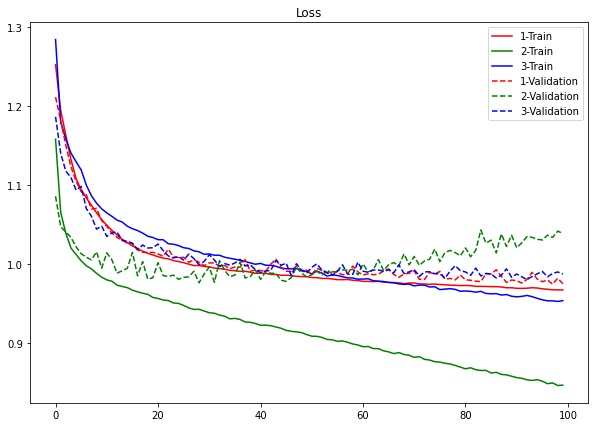

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(history_1.history['loss'], c='r', label='1-Train')
ax.plot(history_2.history['loss'], c='g', label='2-Train')
ax.plot(history_3.history['loss'], c='b', label='3-Train')
ax.plot(history_1.history['val_loss'], c='r', linestyle='--', label='1-Validation')
ax.plot(history_2.history['val_loss'], c='g', linestyle='--', label='2-Validation')
ax.plot(history_3.history['val_loss'], c='b', linestyle='--', label='3-Validation')
ax.legend()
ax.set_title("Loss")
plt.show()

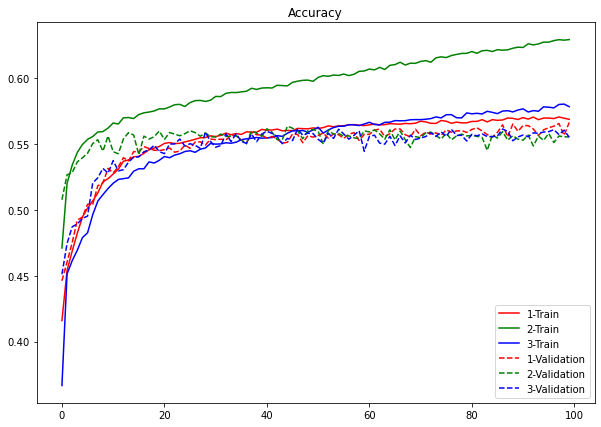

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(history_1.history['accuracy'], c='r', label='1-Train')
ax.plot(history_2.history['accuracy'], c='g', label='2-Train')
ax.plot(history_3.history['accuracy'], c='b', label='3-Train')
ax.plot(history_1.history['val_accuracy'], c='r', linestyle='--', label='1-Validation')
ax.plot(history_2.history['val_accuracy'], c='g', linestyle='--', label='2-Validation')
ax.plot(history_3.history['val_accuracy'], c='b', linestyle='--', label='3-Validation')
ax.legend()
ax.set_title("Accuracy")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("model_1")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predict_1, axis=1)))

model_1
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4292
           1       0.53      0.44      0.48      4297
           2       0.50      0.50      0.50      4144
           3       0.48      0.52      0.50      4228

    accuracy                           0.56     16961
   macro avg       0.55      0.55      0.55     16961
weighted avg       0.55      0.56      0.55     16961



In [ ]:
print("model_2")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predict_2, axis=1)))

model_2
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      4292
           1       0.51      0.49      0.50      4297
           2       0.49      0.46      0.48      4144
           3       0.50      0.44      0.47      4228

    accuracy                           0.55     16961
   macro avg       0.54      0.55      0.55     16961
weighted avg       0.54      0.55      0.55     16961



In [ ]:
print("model_3")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predict_3, axis=1)))

model_3
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      4292
           1       0.51      0.49      0.50      4297
           2       0.50      0.50      0.50      4144
           3       0.52      0.41      0.46      4228

    accuracy                           0.56     16961
   macro avg       0.55      0.55      0.55     16961
weighted avg       0.55      0.56      0.55     16961



Since classes are balanced, we can compare the models by accuracy. Obviously, the first model is the best one, in terms of training cost and overfitting at least, since all models show same test accuracy.

## 3.3 Best Model - Prediction map
Using the best model, we are going to create a prediction map. More specifically, we are going to create a grid on the map and calculate the average of each attribute of points that exist in each cell. Then, the aggregated record will be used to predict a label. 

In [25]:
# Create a 80x80 grid
map_extend_min = data_df[['Start_Lat', 'Start_Lng']].min()
map_extend_max = data_df[['Start_Lat', 'Start_Lng']].max()

xx = np.linspace(map_extend_min['Start_Lng'], map_extend_max['Start_Lng'], 80)
yy = np.linspace(map_extend_min['Start_Lat'], map_extend_max['Start_Lat'], 80)


In [68]:
map_avg = pd.DataFrame(columns=(['x_min', 'x_max', 'y_min', 'y_max'] + columns))
k = 0
# For each cell, find the records that are within the cell and calculate the average of each attribute
for i in range(len(xx[:-1])):
    for j in range(len(yy[:-1])):
        selected_records = data_df.loc[(data_df['Start_Lng'] > xx[i]) &
                                        (data_df['Start_Lng'] < xx[i+1]) &
                                        (data_df['Start_Lat'] > yy[j]) &
                                        (data_df['Start_Lat'] < yy[j+1])]
        avg_data = selected_records[columns].mean()
        if avg_data.isna().sum() == len(columns):
            avg_data[columns] = 0

        map_avg.loc[k, ['x_min', 'x_max', 'y_min', 'y_max']] = [xx[i], xx[i+1], yy[j], yy[j+1]]
        map_avg.loc[k, columns] = avg_data
        k += 1               
# Ignore cells that do not have any record
map_avg_dropped = map_avg.loc[map_avg[columns].sum(axis=1) != 0]

# Set 1 if the mean of a boolean attribute is >= 0.5, otherwise 0
map_avg_dropped.loc[:, bool_lbls] = map_avg_dropped[bool_lbls].applymap(lambda v: 1 if v >= 0.5 else 0)

<ipython-input-68-a58cad6f8eaa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_avg_dropped.loc[:, bool_lbls] = map_avg_dropped[bool_lbls].applymap(lambda v: 1 if v >= 0.5 else 0)


In [70]:
# Prepare data and predict
x = map_avg_dropped.loc[:, columns].values
x_scaled = sc.transform(x[:, :9])
x_scaled = np.concatenate([x_scaled, x[:, 9:]], axis=1)
x_scaled = x_scaled.astype(float)

predicts = model_3.predict(x_scaled)
map_avg_dropped.loc[:, 'predicts'] = np.argmax(predicts, axis=1) + 1

90/90 [==============================] - 0s 3ms/step


<ipython-input-70-b2245ce7ab8d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_avg_dropped.loc[:, 'predicts'] = np.argmax(predicts, axis=1) + 1


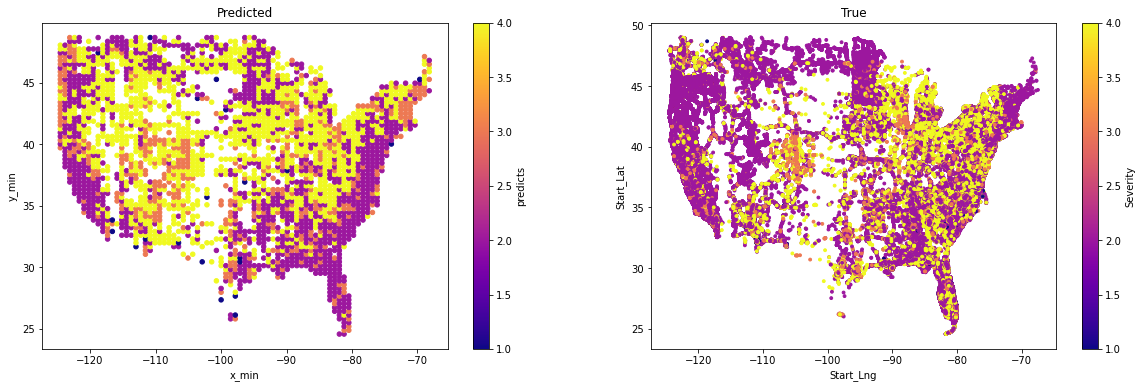

In [71]:
# Plotting maps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
map_avg_dropped.plot.scatter(x='x_min', y='y_min', c='predicts', s=20, cmap='plasma',ax=ax[0], title='Predicted')
data_df.plot.scatter(x='Start_Lng', y='Start_Lat', c='Severity', s=8, cmap='plasma', ax=ax[1], title='True');

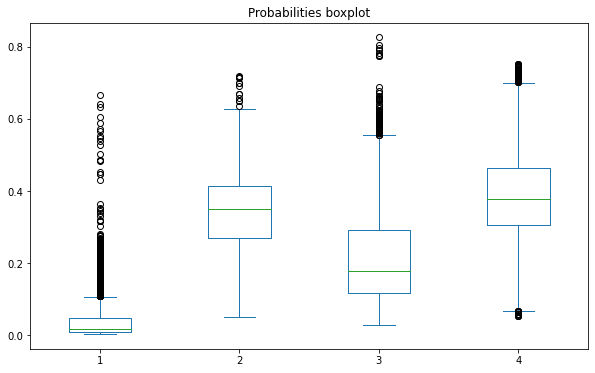

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
pd.DataFrame({"1": predicts[:,0], "2": predicts[:,1], "3": predicts[:,2], "4": predicts[:,3]}).plot.box(ax=ax, title="Probabilities boxplot");